# Modeling Influenza A PR8 (H1N1) in the lungs of mice

This notebook plots the results of parameter optimization using a classical estimation approach and our Integrative Parameter Estimation (IPE) approach.

In [8]:
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'serif'
plt.rcParams['text.usetex'] = True

import seaborn as sns

In [9]:
palette = sns.color_palette('viridis', n_colors=8)
palette

[(0.281412, 0.155834, 0.469201),
 (0.244972, 0.287675, 0.53726),
 (0.190631, 0.407061, 0.556089),
 (0.147607, 0.511733, 0.557049),
 (0.119699, 0.61849, 0.536347),
 (0.20803, 0.718701, 0.472873),
 (0.430983, 0.808473, 0.346476),
 (0.709898, 0.868751, 0.169257)]

In [10]:
palette_2 = sns.color_palette('rocket', n_colors=3)
palette_2

[(0.38092887, 0.12061482, 0.32506528),
 (0.7965014, 0.10506637, 0.31063031),
 (0.95922872, 0.53307513, 0.3748895)]

## Lung Target Cell Model
Define the target cell model with T cell compartment

\begin{align}
\dot U &= - \beta U V \\
\dot I &= \beta U V - \delta_I T I \\
\dot V &= p I - c V \\
\dot T &= \delta_T T_0 + r T V - \delta_T T
\end{align}

In [30]:
def lungModel(Y, t, bet, del_I, p, c, r, del_T, T0):
    U, I, V, T = Y
    
    U = max(0,U)
    I = max(0,I)
    V = max(0,V)
    T = max(0,T)
    # if (t>10):
    #     V = 0

    dU = -bet*U*V
    dI = bet*U*V - del_I*T*I
    dV = p*I - c*V
    dT = r*T*V + del_T*(T0 - T)
    
    return [dU, dI, dV, dT]

In [12]:
parNames=['$V_0$', '$\\beta$', '$\\delta_I$', '$p$', '$c$', '$r$', '$\\delta_T$', 'RSS']

Run all parameter set simulations

In [13]:
def simulations(dfParams, Y0, t, simNum):
    U = []
    I = []
    V = []
    T = []
    
    for i in range(simNum):
        bet = dfParams['$\\beta$'][i]
        del_I = dfParams['$\\delta_I$'][i]
        p = dfParams['$p$'][i]
        c = dfParams['$c$'][i]
        r = dfParams['$r$'][i]
        del_T = dfParams['$\\delta_T$'][i]
        U0, I0, V0, T0 = Y0
        V0 = dfParams['$V_0$'][i]
        Y0 = [U0, I0, V0, T0]
    
        sol = odeint(lungModel, Y0, t, args=(bet, del_I, p, c, r, del_T, T0))
        U.append(sol[:,0])
        I.append(sol[:,1])
        V.append(sol[:,2])
        T.append(sol[:,3])

    return [U, I, V, T]

## Recovering Parameters

In [36]:
dfViralData = pd.read_csv('influenza/viralLoad.data', sep=' ')

In [37]:
dfViralData.head(4)

,Days,Virus
0,2,448592.338
1,2,1126813.007
2,2,4262158.829
3,2,1126813.007


### Quantitative estimation

In [38]:
dfParams = pd.read_csv('influenza/bestPars_quant.dat', sep=' ', names=parNames)

In [39]:
dfParams.head()

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
0,124930.00,1.058700e-06,1.235600e-08,0.70871,2.4056,3.078400e-06,1.29270,5.6111
1,1694.30,3.323000e-07,2.657100e-06,10.56600,2.1749,4.722500e-07,0.57277,9.6666
2,101.55,1.763900e-05,1.000000e-08,0.51498,2.5517,7.850400e-07,0.01000,5.4143
3,519210.00,8.908500e-08,1.330900e-07,6.83320,3.5515,1.068200e-06,0.37591,5.9652
4,10053.00,2.471300e-07,1.684300e-06,9.38630,3.0174,4.020600e-07,0.38455,6.8065


In [40]:
U0 = 1e7
I0 = 0
V0 = 0
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 35, 561)

simNumber = dfParams.shape[0]
# simNumber = 100

U_Qt, I_Qt, V_Qt, T_Qt = simulations(dfParams, Y0, t, simNumber)

In [41]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQt_2D = np.array(V_Qt)
TQt_2D = np.array(T_Qt)
median_VQt = np.median(VQt_2D, axis=0)
confidence_VQt = np.percentile(VQt_2D, [2.5, 97.5], axis=0)
median_TQt = np.median(TQt_2D, axis=0)
confidence_TQt = np.percentile(TQt_2D, [2.5, 97.5], axis=0)
# mean_VQt = np.mean(VQt_2D, axis=0)
# std_VQt = np.std(VQt_2D, axis=0)

In [42]:
dfParams_quant = dfParams.drop(columns=['RSS']).melt(var_name='Parameters', value_name='Values')

### Qualitative T cell level

In [43]:
dfTcellQual = pd.read_csv('influenza/qualTcell.data', sep=' ')

Tmax = 1e7
T0 = 1e6
dfTcellQual['Tmin'] = dfTcellQual['Tmin']*(Tmax-T0) + T0
dfTcellQual['Tmax'] = dfTcellQual['Tmax']*(Tmax-T0) + T0

In [44]:
dfTcellQual

,tmin,tmax,Tmin,Tmax
0,0.0,6.5,1000000.0,2664226.0
1,6.5,13.5,7242094.0,10000000.0
2,13.5,24.5,2664226.0,7242094.0
3,24.5,33.5,1000000.0,2664226.0


In [45]:
dfParams = pd.read_csv('influenza/bestPars_qual.dat', sep=' ', names=parNames)

In [46]:
dfParams.tail(4)

,$V_0$,$\beta$,$\delta_I$,$p$,$c$,$r$,$\delta_T$,RSS
183,696880.00,3.487800e-07,2.430100e-07,1.35360,2.8158,9.725700e-07,0.14872,8.9207
184,556180.00,8.105000e-07,2.043000e-07,0.60383,1.6732,7.702800e-07,0.23164,4.2104
185,197.45,1.580900e-05,1.362200e-07,0.26777,1.7971,9.813900e-07,0.07873,5.6415
186,337450.00,6.765900e-07,9.792900e-08,5.68480,17.1350,9.061900e-07,0.19844,13.2190


In [47]:
U0 = 1e7
I0 = 0
V0 = 0
T0 = 1e6
Y0 = [U0, I0, V0, T0]

t = np.linspace(0, 35, 561)

simNumber = dfParams.shape[0]
# simNumber = 100

U_Ql, I_Ql, V_Ql, T_Ql = simulations(dfParams, Y0, t, simNumber)

In [48]:
# Convert list of arrays to a 2D numpy array and compute median and confidence innterval
VQl_2D = np.array(V_Ql)
TQl_2D = np.array(T_Ql)
median_VQl = np.median(VQl_2D, axis=0)
confidence_VQl = np.percentile(VQl_2D, [2.5, 97.5], axis=0)
median_TQl = np.median(TQl_2D, axis=0)
confidence_TQl = np.percentile(TQl_2D, [2.5, 97.5], axis=0)
# mean_VQl = np.mean(VQl_2D, axis=0)
# std_VQl = np.std(VQl_2D, axis=0)

In [49]:
dfParams_qual = dfParams.drop(columns=['RSS']).melt(var_name='Parameters', value_name='Values')

### Simulation plots

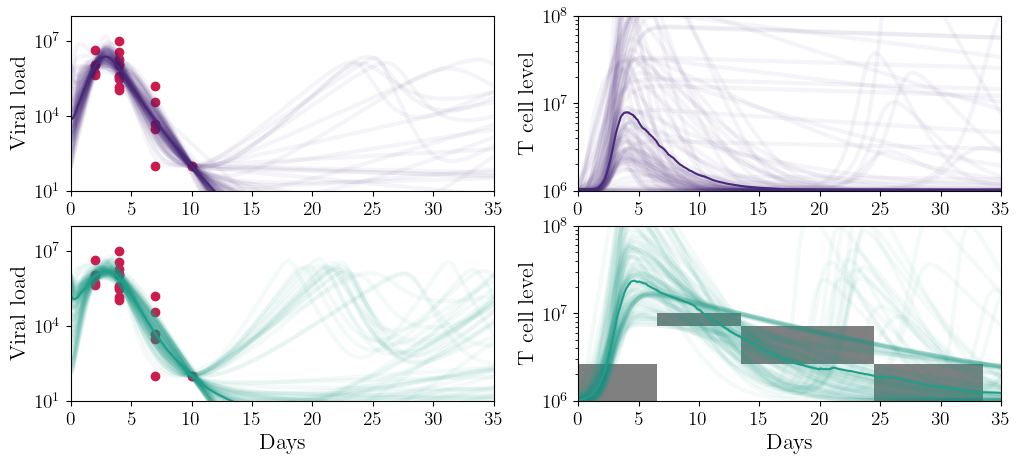

In [50]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12,5))

plotNums = 100
for i in range(plotNums):
    axs[0,0].plot(t, V_Qt[i], lw=3, color=palette[0], alpha=0.05)
    axs[0,1].plot(t, T_Qt[i], lw=3, color=palette[0], alpha=0.05)

    axs[1,0].plot(t, V_Ql[i], lw=3, color=palette[4], alpha=0.05)
    axs[1,1].plot(t, T_Ql[i], lw=3, color=palette[4], alpha=0.05)

axs[0,0].plot(t, median_VQt, lw=1.5, color=palette[0])
axs[0,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette_2[1], marker="o")
axs[0,0].set_yscale('log')
axs[0,0].set_xlim((0, 35))
axs[0,0].set_ylim((1e1, 1e8))

axs[0,1].plot(t, median_TQt, lw=1.5, color=palette[0])
axs[0,1].set_yscale('log')
axs[0,1].set_xlim((0, 35))
axs[0,1].set_ylim((1e6, 1e8))

axs[1,0].plot(t, median_VQl, lw=1.5, color=palette[4])
axs[1,0].scatter(x=dfViralData['Days'], y=dfViralData['Virus'], color=palette_2[1], marker="o")
axs[1,0].set_yscale('log')
axs[1,0].set_xlim((0, 35))
axs[1,0].set_ylim((1e1, 1e8))

axs[1,1].plot(t, median_TQl, lw=1.5, color=palette[4])
axs[1,1].set_yscale('log')
axs[1,1].set_xlim((0, 35))
axs[1,1].set_ylim((1e6, 1e8))

for i in range(len(dfTcellQual['tmin'])):
    tmin = dfTcellQual['tmin'].values[i]
    Tmin = dfTcellQual['Tmin'].values[i]
    width = dfTcellQual['tmax'].values[i] - tmin
    height = dfTcellQual['Tmax'].values[i] - Tmin
    rect = plt.Rectangle((tmin, Tmin), width, height, fc='gray')
    axs[1,1].add_patch(rect)

axs[0,0].set_ylabel('Viral load')
axs[0,1].set_ylabel('T cell level')

axs[1,0].set_ylabel('Viral load')
axs[1,1].set_ylabel('T cell level')

axs[1,0].set_xlabel('Days')
axs[1,1].set_xlabel('Days')

# axs[0,0].text(76, 4.2, r'\textbf{a}', fontsize=22)
# axs[0,1].text(76, 3.5, r'\textbf{b}', fontsize=22)
# axs[1,0].text(76, 4.2, r'\textbf{c}', fontsize=22)
# axs[1,1].text(76, 3.5, r'\textbf{d}', fontsize=22)

# for i in range(2):
#     axs[i,0].set_ylim((-0.1,5.1))
#     axs[i,1].set_ylim((0.5,4.1))

# plt.setp(axs, xlim=(-2,82))

# plt.savefig("cycleLV_graphs_sel.svg", transparent=True)

plt.show()

### Parameter distribution

In [470]:
dfParams_quant['Strategy'] = 'I'
dfParams_qual['Strategy'] = 'II'
dfParams_all = pd.concat([dfParams_quant, dfParams_qual])
# dfParams_all = dfParams_quant.copy()

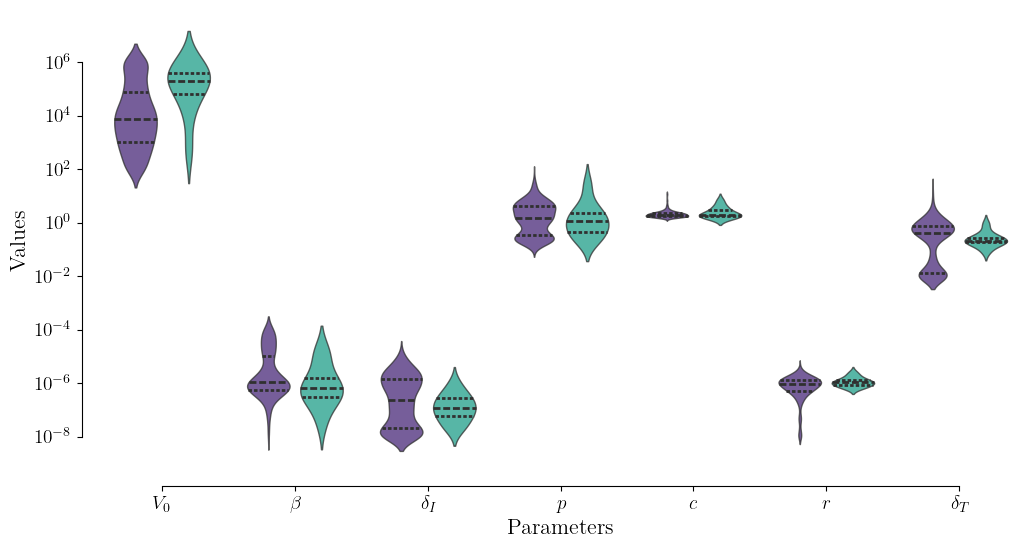

In [472]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(12,6), facecolor='white')

# colors = [palette[0], palette[2], palette[4], palette[6]]
colors = [palette[0], palette[4]]

# axs = sns.violinplot(data=dfParams_all, x='Parameters', y='Values', log_scale=True,
#                alpha=0.75, linewidth=1.0, density_norm="count", gap=0.2,
#                inner="quart", saturation=1, inner_kws=dict(linewidth=2))

axs = sns.violinplot(data=dfParams_all, x='Parameters', y='Values', hue='Strategy', log_scale=True,
               palette=colors, alpha=0.75, linewidth=1.0, density_norm="count", gap=0.2,
               inner="quart", saturation=1, inner_kws=dict(linewidth=2))

sns.despine(offset=10, trim=True);

plt.legend([],[], frameon=False)

# plt.savefig("cycleLV_boots.svg", transparent=True)

plt.show()

In [471]:
dfParams_qual

,Parameters,Values,Strategy
0,$V_0$,777410.000000,II
1,$V_0$,201520.000000,II
2,$V_0$,206320.000000,II
3,$V_0$,47858.000000,II
4,$V_0$,265020.000000,II
...,...,...,...
65,$\delta_T$,0.141970,II
66,$\delta_T$,0.273180,II
67,$\delta_T$,0.197820,II
68,$\delta_T$,0.084173,II
